# Heart Lung Disease Detection

The purpose of this notebook is to analyze the problem of the heart lung disease detection from a dataset containing lung sound recordings from 112 subjects (35 healthy and 77 unhealthy), with ages ranging from 21 to 90 years old. The recordings are captured using an electronic stethoscope and include sounds from various lung and heart ailments such as asthma, heart failure, pneumonia, bronchitis, pleural effusion, lung fibrosis, and chronic obstructive pulmonary disease (COPD), as well as normal breathing sounds.

This document state the process required by the hiring company (SAMAY) in order to demonstrate the techinal skills in the ML field for the candidate.

## Part 1 (EDA)

This part is about the Exploratory Data Analysis of the provided dataset. Let us answer the requirements as follows:

### How did you load the dataset into your Python environment? 

What libraries were used, and why? Provide a code snippet that verifies the correct loading of the data and displays the first few rows. 

Let us display a comparison between a healthy vs. pathological in their waves.




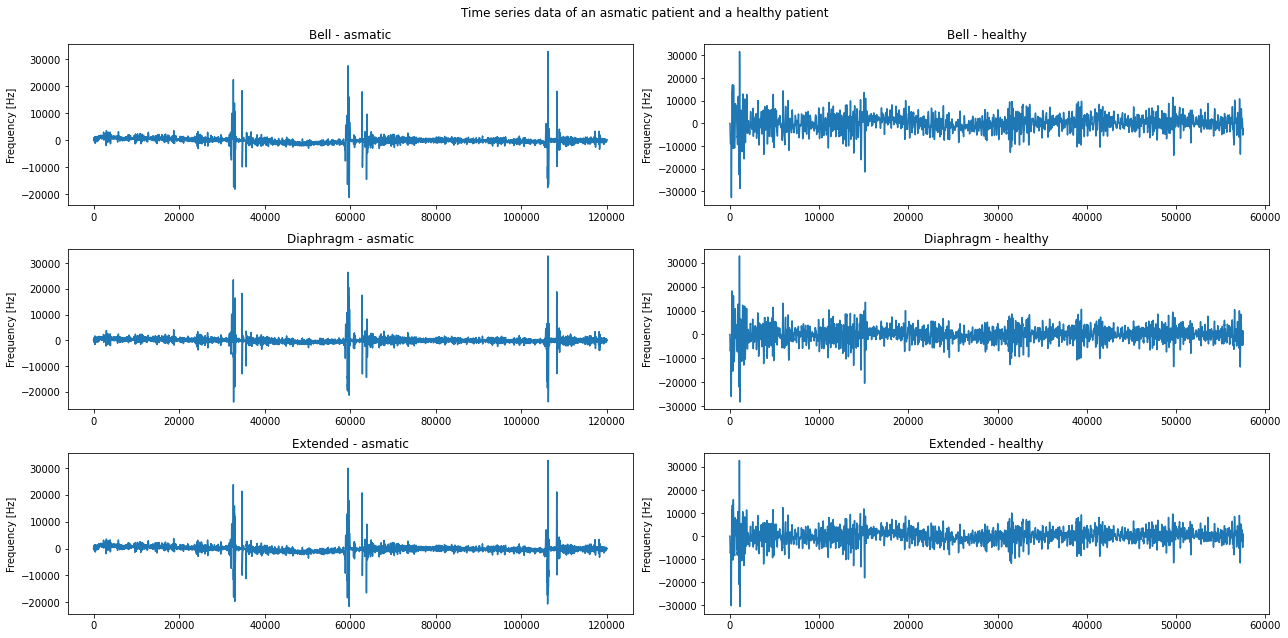

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile

# main path
audio_path = '../dataset/AudioFiles/'
# Reading the wav file
filter_names = {"B": "Bell", "D": "Diaphragm", "E": "Extended"}
colors = {"B": "blue", "D": "green", "E": "red"}
post_fix = {'asmatic': "P1_Asthma,I E W,P L L,70,M.wav", 'healthy': 'P94_N,N,P L L,24,M.wav'}
fig, axs = plt.subplots(3, 2, figsize=(18,9))

for j, subject in enumerate(['asmatic', 'healthy']):
    for i, filter in enumerate(["B", "D", "E"]):
        sample_rate, sample_data = wavfile.read(audio_path + f'{filter}{post_fix[subject]}')
        df_sample = pd.DataFrame(sample_data)
        sns.lineplot(data=df_sample, ax=axs[i, j], legend=False, color=colors[filter])
        axs[i, j].set_title(f'{filter_names[filter]} - {subject}')
        axs[i, j].set_ylabel('Frequency [Hz]') 

fig.suptitle('Time series data of an asmatic patient and a healthy patient')
plt.tight_layout()
plt.show()

We can see notable differences in terms of amplitude between non-pathological and asmatics. From the same dataset, there is also the annotation dataset (metadata) where we can see the labels of each recording:

In [69]:
file_name = '../dataset/Data annotation.xlsx'
df_meta = pd.read_excel(file_name, sheet_name='Sheet1', header=0, usecols="A:E")
df_meta.dropna(inplace=True)
df_meta.sample(5)
df_meta.index.name = "SubjectNo"
df_meta

,Age,Gender,Location,Sound type,Diagnosis
SubjectNo,,,,,
0,70.0,M,P L L,I E W,Asthma
1,52.0,F,P L L,E W,Asthma
2,50.0,F,P L L,I E W,Asthma
3,72.0,F,P R L,I C,Heart Failure + Lung Fibrosis
4,71.0,M,P R L,I C E W,Heart Failure + COPD
...,...,...,...,...,...
107,63.0,M,P R L,E W,COPD
108,26.0,M,P L M,N,N
109,62.0,M,P L L,E W,COPD


In [35]:
print(df_meta.info())

print(f"Data type of the time series {type(sample_data)}, and the datatype of the rate is {type(sample_rate)}")

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         112 non-null    float64
 1   Gender      112 non-null    object 
 2   Location    112 non-null    object 
 3   Sound type  112 non-null    object 
 4   Diagnosis   112 non-null    object 
dtypes: float64(1), object(4)
memory usage: 5.2+ KB
None
Data type of the time series <class 'numpy.ndarray'>, and the datatype of the rate is <class 'int'>


### What is the structure of the dataset and the data types of each column after loading? Are there any columns that require type conversion for further analysis? How would you handle these conversions?

In terms of the audio files, after conversion we have the information from the rate (integer) and an array for the time series data. For the annotations dataset, it is observed that there are four object data types, which can be converted through one-hot encoding to numbers. Let us see the size of each category per column.


In [31]:
count_dict = {}
for column in df_meta.columns[1:]:
    count_dict.update({column: df_meta[column].value_counts()})
count_dict['Diagnosis']


Diagnosis
N                                 35
Asthma                            17
heart failure                     15
asthma                            15
COPD                               8
pneumonia                          5
Lung Fibrosis                      4
Heart Failure                      3
BRON                               3
Heart Failure + COPD               2
Plueral Effusion                   2
Heart Failure + Lung Fibrosis      1
Asthma and lung fibrosis           1
copd                               1
Name: count, dtype: int64

In [32]:
count_dict['Sound type']

Sound type
E W          39
N            35
Crep         23
C             7
I E W         2
I C E W       2
I C B         2
I C           1
Bronchial     1
Name: count, dtype: int64

In [33]:
count_dict['Location']

Location
P R L     24
P L L     16
P R M     16
P R U     14
P L M     12
P L U     11
A R U      6
A R M      4
A R L      4
P L L      3
A L U      2
Name: count, dtype: int64

From the __Diagnosis__ column we can combine the __heart attack__ coincidences, as well as some labels as ["Asthma", "astmha"] or [COPD, copd]

In [50]:
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace(['Heart Failure + COPD', 
                    'Heart Failure + Lung Fibrosis ', 'heart failure'], 'Heart Failure')
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace(['asthma','Asthma and lung fibrosis'], 'Asthma')
df_meta['Diagnosis'] = df_meta['Diagnosis'].replace('copd', 'COPD')
count_dict['Diagnosis'] = df_meta['Diagnosis'].value_counts()
count_dict['Diagnosis']

Diagnosis
N                   35
Asthma              33
Heart Failure       21
COPD                 9
pneumonia            5
Lung Fibrosis        4
BRON                 3
Plueral Effusion     2
Name: count, dtype: int64

### Are there missing or anomalous values in the dataset? Describe the method(s) you used to identify these issues and your approach to handling them.

There are no missing values from now and we have merged the diagnosis categories. It is no observed any other alteration in the metadata. We will need to see the time series in order to determine some outliers. By inspection, It is observed a bias in the age of subjects in the Normal (N) category.

### Generate and interpret the descriptive statistics of the dataset. What insights can you derive from these statistics, and how might they influence your preprocessing steps?

Below we can see that 61.6% of the population is male and 38.39 for female subjects. Moreover, the violinplot show a normal distribution with no outliers in the nominal category.



Gender
M    69
F    43
Name: count, dtype: int64


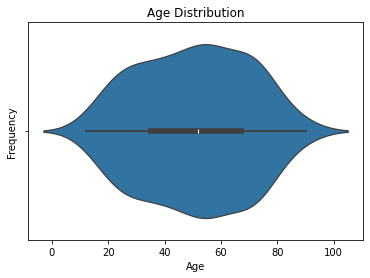

In [57]:
print(count_dict['Gender'])
sns.violinplot(x=df_meta["Age"])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

### Analyze the balance of the dataset across the different conditions (e.g.,asthma, pneumonia). How many recordings are there per condition? Provide a visualization (such as a bar chart) showing the distribution of classes and discuss potential model training challenges due to these distributions.

Below it is depicted the corresponding distributions of the categories

/var/folders/_r/n2xzdrkx23gbz70wwfg4p9w00000gn/T/ipykernel_34721/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
/var/folders/_r/n2xzdrkx23gbz70wwfg4p9w00000gn/T/ipykernel_34721/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
/var/folders/_r/n2xzdrkx23gbz70wwfg4p9w00000gn/T/ipykernel_34721/1151014312.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value.index, y=value.va

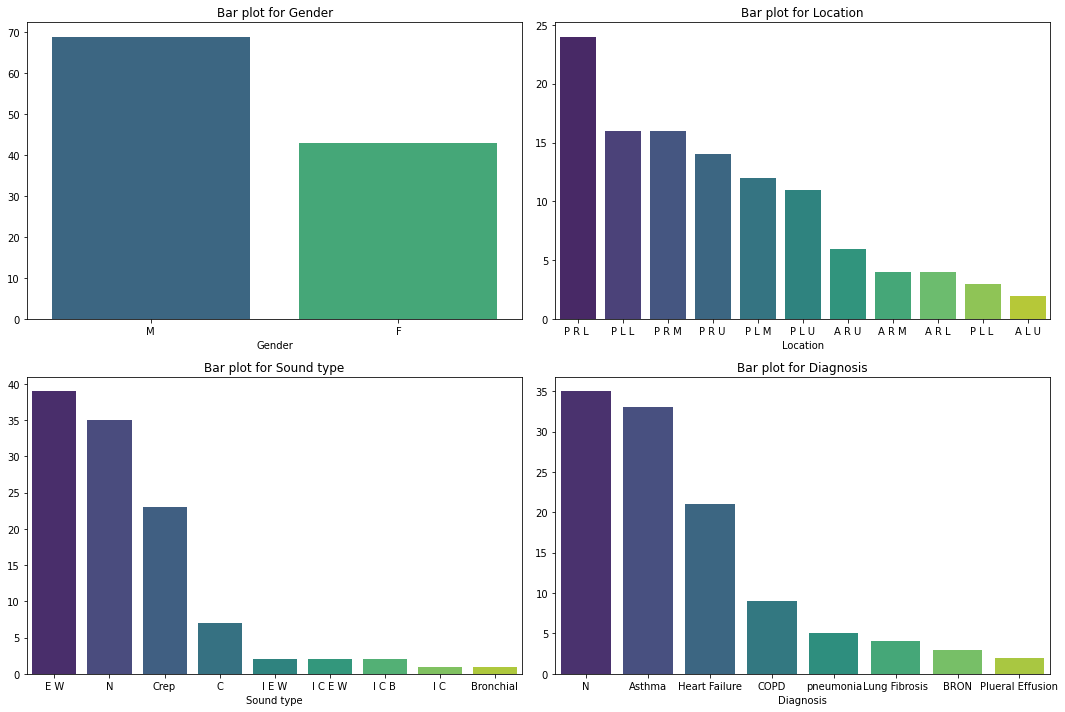

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, (key, value) in enumerate(count_dict.items()):
    sns.barplot(x=value.index, y=value.values, ax=axs[i//2, i%2], palette='viridis')
    axs[i//2, i%2].set_title(f'Bar plot for {key}')

plt.tight_layout()
plt.show()

The plot above shows the common pathologies are Asthma and Heart Failure, followed by COPD and pneumonia. The remaining pathologies will be difficult to classify isolately as there are no more samples to identify those. 

The common location are the Posterior (the six first quantities) and Lower (first two in terms of quantity) zones. Anterior Left Upper and Posterior Left Lower have the least samples. On the other hand, the most common sound are the Experiatory Wheezes and crepitations. The remaining noises could be non signinficant as the samples are less than ten.

As an initial strategy, we could only take the diagnosis, age, gender and the time series feature extraction as the main features of the problem. If necessary we can include the Sound and Location types. Even though the original paper took out the age to not bias the model.

### How many recordings do we have per condition?

Theoretically, the number of recordings is each count condition multiplied by each of the filters (Bell, Diaphragm and Extended), in other words:


In [67]:
count_dict['Diagnosis']*3

Diagnosis
N                   105
Asthma               99
Heart Failure        63
COPD                 27
pneumonia            15
Lung Fibrosis        12
BRON                  9
Plueral Effusion      6
Name: count, dtype: int64

## PART 2

This part focuses on signal processing and feature engineering, particularly in the context of audio or time-series data. Candidates may be asked to perform tasks like analyzing audio signals, visualizing data (e.g., waveforms), extracting relevant features (e.g., MFCC features), and explaining their significance.

- Explore and preprocess the acoustic dataset, including data cleaning, normalization, and feature engineering as needed.
- Conduct exploratory data analysis (EDA) to gain insights into the distribution and characteristics of the acoustic data.

### Arranging the data so that we 

In [70]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

/Users/sorryrobots/opt/anaconda3/envs/deeptools/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: dlopen(/Users/sorryrobots/opt/anaconda3/envs/deeptools/lib/python3.9/site-packages/torchaudio/lib/libtorchaudio.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A8B82A3B-DC38-3A7D-9F0C-888C359C49FE> /Users/sorryrobots/opt/anaconda3/envs/deeptools/lib/python3.9/site-packages/torchaudio/lib/libtorchaudio.so
  Expected in:     <57D24B07-8B24-3888-A2B5-2B4C95434BA4> /Users/sorryrobots/opt/anaconda3/envs/deeptools/lib/python3.9/site-packages/torch/lib/libc10.dylib